# Detecting Fake Job Postings with Machine Learning

#### Project Storyline: Fighting Fraud in the Job Market

In today’s digital age, millions of online job platforms have become targets for scammers posting fake jobs to steal personal data or charge fake fees. These fraudulent listings erode trust and waste job seekers' time. To help job boards maintain safety and efficiency. These fraudulent jobs often:

- Collect personal information under false pretenses
- Charge fake application or training fees
- Waste job seekers’ time and damage their trust

To protect users and improve trust in online job boards, we aim to build a machine learning model that flags suspicious job postings.

##### Stakeholder
The key stakeholder is online job platforms (e.g., LinkedIn, Indeed). They aim to protect job seekers from scams, maintain trust, and reduce manual moderation by using automated fake job detection.

##### Objective

Build a classification model that can predict whether a job listing is **fraudulent (1)** or **legitimate (0)** based on its content.

##### Business Questions
1. Can we predict fake job postings based on content like description, location, and telecommuting?

2. Which features are most predictive of fraudulent listings?

3. How well can we catch fake listings without misclassifying too many real ones?

4. How can this model be used to assist or automate moderation workflows?

##### Why Machine Learning?

Rule-based systems can’t keep up with evolving scams. With machine learning, we can:

- Learn from patterns across thousands of job postings
- Automatically detect suspicious listings
- Support human moderators with predictions

##### Dataset

We’ll use the “Fake Job Postings” dataset from [Kaggle](https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction). The dataset includes real and fake job posts, with features such as:

- Job title, company, location
- Description, requirements, benefits
- Telecommuting, company logo, employment type

Our target variable is:
- `fraudulent`: 0 = Real job, 1 = Fake job

---

### **Let’s begin by importing the dataset and exploring the data.**


In [27]:
import pandas as pd

df = pd.read_csv("../data/fake_job_postings.csv")
df.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [29]:
print("Dataset shape (rows, columns):", df.shape)

Dataset shape (rows, columns): (17880, 18)


In [30]:
# Check missing values count per column
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


##### Handling Missing Values

The dataset has several columns with missing values. Before building our model, it's important to decide how to handle these gaps. 

- Columns with too many missing values might be dropped or carefully imputed.
- Important features with few missing values can be filled with sensible defaults or placeholders.
- The target variable `fraudulent` has no missing data, so we don't need to worry about it.
---
##### **Let’s explore and handle missing values step-by-step.**


In [31]:
# fill missing text columns with "uknown"
text_columns = ['company_profile', 'benefits', 'requirements', 'description']
for columns in text_columns:
    df[columns] = df[columns].fillna('unknown')


In [32]:
# filling in missing categorical columns with mode
categorical_columns = ['department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for columns in categorical_columns:
    mode = df[columns].mode()[0]
    df[columns] = df[columns].fillna(mode)

In [33]:
# Filling in missing in 'location' with "Unknown"
df['location'] = df['location'].fillna("unknown").str.strip()
df.loc[df['location'] == '', 'location'] = "unknown"

# Filling in missing in 'salary_range' with "Not Disclosed"
df['salary_range'] = df['salary_range'].fillna("Not Disclosed").str.strip()

# (Optional) Check some cleaned columns
df[['location', 'salary_range']].head(10)


,location,salary_range
0,"US, NY, New York",Not Disclosed
1,"NZ, , Auckland",Not Disclosed
2,"US, IA, Wever",Not Disclosed
3,"US, DC, Washington",Not Disclosed
4,"US, FL, Fort Worth",Not Disclosed
5,"US, MD,",Not Disclosed
6,"DE, BE, Berlin",20000-28000
7,"US, CA, San Francisco",Not Disclosed
8,"US, FL, Pensacola",Not Disclosed
9,"US, AZ, Phoenix",Not Disclosed


In [34]:
df.isnull().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

---

After carefully inspecting the dataset, I performed data cleaning to prepare it for analysis and modeling:

- **Filled missing text fields** such as `company_profile`, `benefits`, `requirements`, and `description` with `"Unknown"` to avoid empty text entries.
- **Imputed missing categorical columns** like `department`, `employment_type`, `required_experience`, `required_education`, `industry`, and `function` using the most frequent value (mode) in each column.
- **Cleaned `location` column** by filling missing values with `"Unknown"` to handle incomplete geographic data.
- **Standardized `salary_range`** by filling missing or undisclosed salaries with `"Not Disclosed"`, which means the employer chose **not to publish or reveal** the salary for the position to keep data consistent.
- After cleaning, the dataset no longer contains missing values, making it ready for further analysis.

This cleaned dataset ensures better quality inputs for building our machine learning model to detect fake job postings.


In [35]:
# Saving the cleaned dataset to a new CSV file
df.to_csv("data/cleaned_fake_job_postings.csv", index=False)
print("Cleaned dataset saved successfully.")

Cleaned dataset saved successfully.


---
#### **Exploratory Data Analysis (EDA)**

In this section, we begin exploring the dataset to better understand the characteristics of job postings. This will help us identify patterns, trends, and potential red flags that differentiate real job listings from fraudulent ones.

We'll start with general EDA to get a high-level overview of the dataset, including:

- Basic structure and summary statistics
- Distribution of the target variable (`fraudulent`)
- Common job titles, locations, and companies
- Frequency of missing values
- Initial observations about salary and job posting metadata

This foundational understanding will guide our deeper analysis and help refine our approach for building a classification model.


In [36]:
# Shape and data types
print("Dataset shape:", df.shape)
print("\nData types:\n", df.dtypes)

# Summary statistics for numerical columns
print("\nSummary statistics (numerical):")
display(df.describe())

# Summary statistics for categorical columns
print("\nSummary statistics (categorical):")
display(df.describe(include='object'))


Dataset shape: (17880, 18)

Data types:
 job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

Summary statistics (numerical):


,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000



Summary statistics (categorical):


,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
count,17880,17880,17880,17880,17880,17880,17880,17880,17880,17880,17880,17880,17880
unique,11231,2991,1337,875,1710,14802,11969,6206,5,7,13,131,37
top,English Teacher Abroad,"GB, LND, London",Sales,Not Disclosed,unknown,"Play with kids, get paid for it Love travel? J...",unknown,unknown,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology
freq,311,736,12098,15012,3308,379,2695,7210,15091,10859,13250,6637,8204


Target Variable Overview

Our main goal is to predict whether a job posting is **fraudulent (1)** or **legitimate (0)**. 

Understanding the distribution of this target variable is crucial because:

- It tells us if the dataset is balanced or skewed towards one class.
- Imbalanced classes may require special handling during modeling.

##### **Let's take a look at how many fake vs real job postings we have in the dataset.**


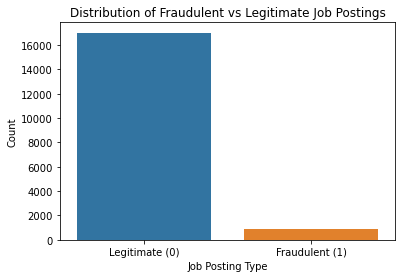

0    17014
1      866
Name: fraudulent, dtype: int64


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# plotting the distribution of the target variables
plt.figure(figsize=(6,4))
sns.countplot(x='fraudulent', data=df)
plt.title('Distribution of Fraudulent vs Legitimate Job Postings')
plt.xlabel('Job Posting Type')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Legitimate (0)', 'Fraudulent (1)'])
plt.show()

# let us also print counts to give the exact number behind the visual
print(df['fraudulent'].value_counts())

***Distribution of Fraudulent vs Legitimate Job Postings***

The bar plot shows the count of job postings labeled as either **Legitimate (0)** or **Fraudulent (1)**.

- The **x-axis** represents the job posting type:
  - **Legitimate (0)**: Genuine job postings.
  - **Fraudulent (1)**: Fake or scam job postings.

- The **y-axis** indicates the number of postings in each category.

From the plot, it is clear that legitimate postings greatly outnumber fraudulent ones. This means our dataset is imbalanced, with many more genuine listings than fake ones.

This class imbalance is important to consider in future modeling steps, as predictive models may become biased toward the majority (legitimate) class.

---

**Explore Categorical Features**

Here we visualize the distributions of key categorical variables to understand the common categories and any class imbalance within those features.


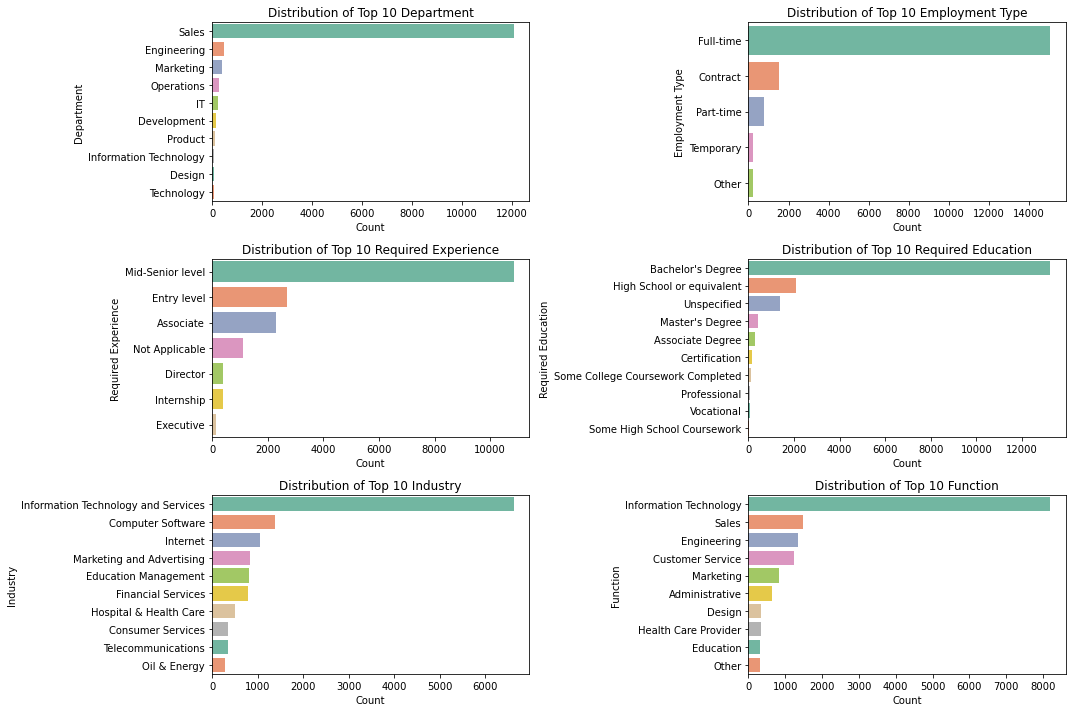

In [58]:
categorical_columns = ['department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

# Setting up the subplot grid of 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()


for i, column in enumerate(categorical_columns):
    top_values = df[column].value_counts().head(10)

    sns.barplot(x=top_values.values, y=top_values.index, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Distribution of Top 10 {column.replace("_", " ").title()}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column.replace("_", " ").title())

# Adjusting the layout to avoid overlapping
plt.tight_layout()
plt.show()


**Categorical Features vs Fraudulent Target**

These plots show how the different categories relate to whether a job posting is fraudulent or legitimate, revealing possible patterns or risk factors.


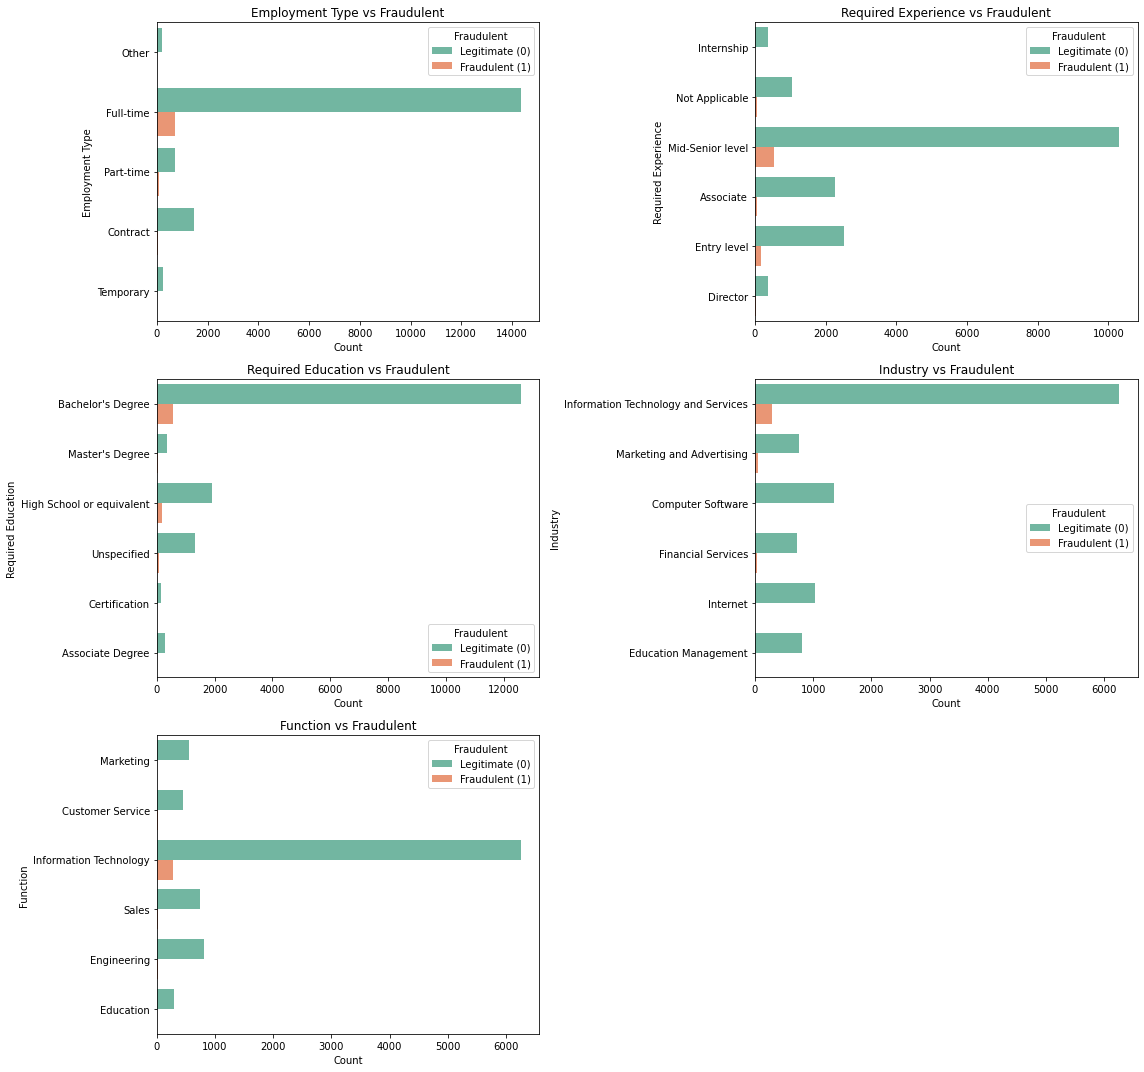

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
axes = axes.flatten()

# plotting each features
for i, column in enumerate(categorical_columns):
    top_categories = df[column].value_counts().nlargest(6).index
    df = df[df[column].isin(top_categories)]

    sns.countplot(data=df, y=column, hue='fraudulent', ax=axes[i], palette='Set2')
    axes[i].set_title(f'{column.replace("_", " ").title()} vs Fraudulent')
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel(column.replace("_", " ").title())
    axes[i].legend(title='Fraudulent', labels=['Legitimate (0)', 'Fraudulent (1)'])

# removing the unused subplots
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()



These plots show that fraudulent jobs tend to avoid requiring high experience, specific education, or commitment (like full-time work). They also appear in broad, easy-to-fake categories. This insight can guide your feature selection and model strategy later.

**Explore Text Columns Length**

Text length distributions in key columns might help us understand if fraudulent posts tend to have shorter or longer descriptions or requirements, which could be an important feature.



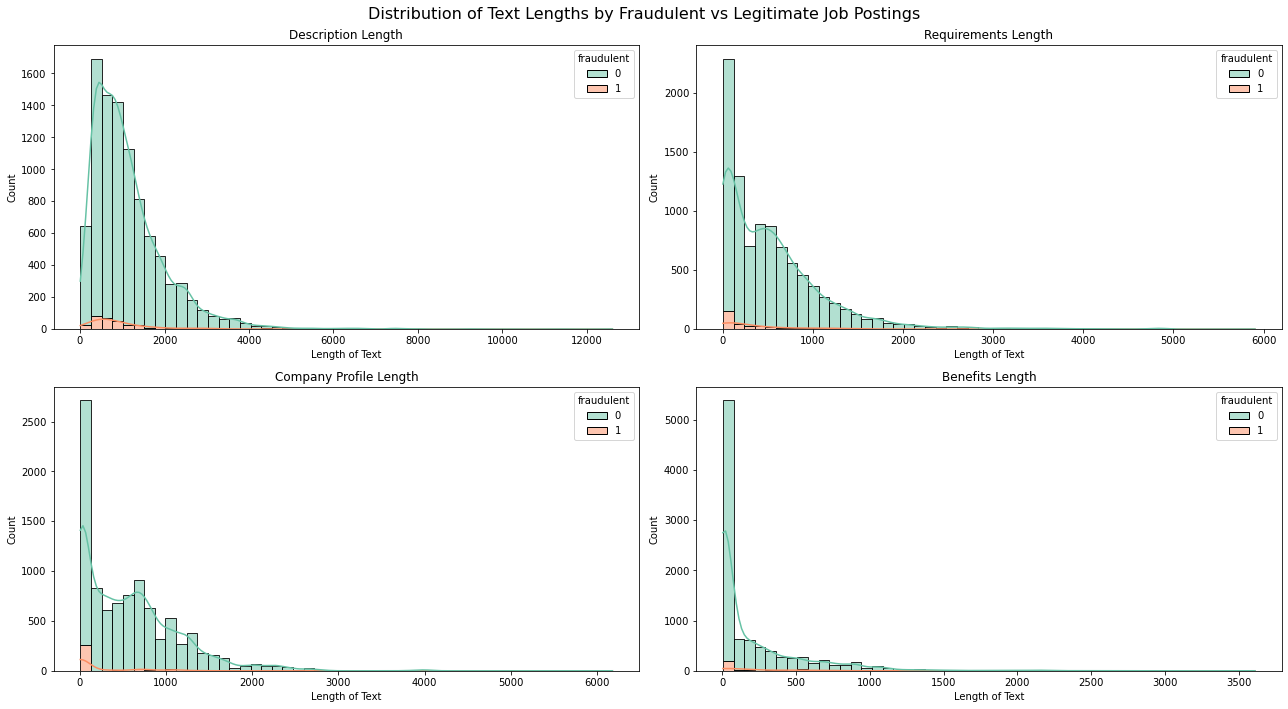

In [98]:
text_columns = ['description', 'requirements', 'company_profile', 'benefits']

# Creating new columns for text lengths
for column in text_columns:
    df[f'{column}_length'] = df[column].apply(lambda x: len(str(x)))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
fig.suptitle('Distribution of Text Lengths by Fraudulent vs Legitimate Job Postings', fontsize=16)
axes = axes.flatten()

for i, column in enumerate(text_columns):
    sns.histplot(data=df, x=f'{column}_length', hue='fraudulent', bins=50, kde=True, ax=axes[i], palette='Set2', multiple='stack')
    axes[i].set_title(f'{column.replace("_", " ").title()} Length')
    axes[i].set_xlabel('Length of Text')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


Analyzing the length of key text fields (`description`, `requirements`, `company_profile`, `benefits`) and comparing them across fraudulent and legitimate job postings.

- **Description**: Legitimate jobs usually have longer, detailed descriptions. Fraudulent ones are shorter.
- **Requirements**: Real jobs list clear requirements. Fake ones often skip or keep it brief.
- **Company Profile**: Many are missing, but when present, legitimate jobs provide more info.
- **Benefits**: Most postings lack detailed benefits; not very useful for distinguishing fraud.

**Insight**: Short or missing text fields may signal fraudulent postings and can be useful features for modeling.


**Text Length by Fraudulent Status**
Box plots reveal that fraudulent job postings tend to have shorter or less consistent text content across fields like description, requirements, and company_profile. Legitimate postings usually show a wider range and longer average lengths, suggesting that fake jobs may use brief or templated content.


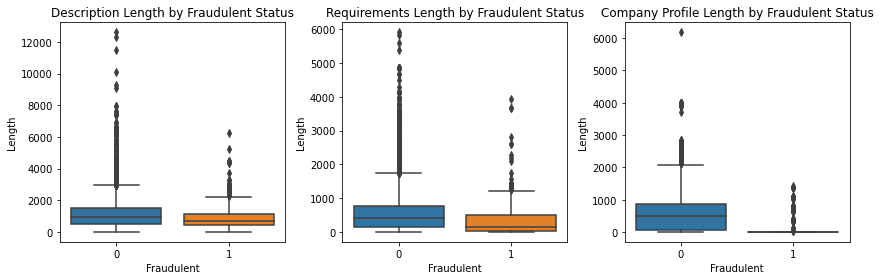

In [107]:
text_columns = ['description_length', 'requirements_length', 'company_profile_length']

plt.figure(figsize=(12, 4))
for i, column in enumerate(text_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='fraudulent', y=column, data=df)
    plt.title(f'{column.replace("_", " ").title()} by Fraudulent Status')
    plt.xlabel('Fraudulent')
    plt.ylabel('Length')
plt.tight_layout()
plt.show()


 **Correlation Heatmap for Numerical Columns**
 The correlation heatmap helps identify linear relationships between numerical variables and the target. Strong correlations can guide feature selection.


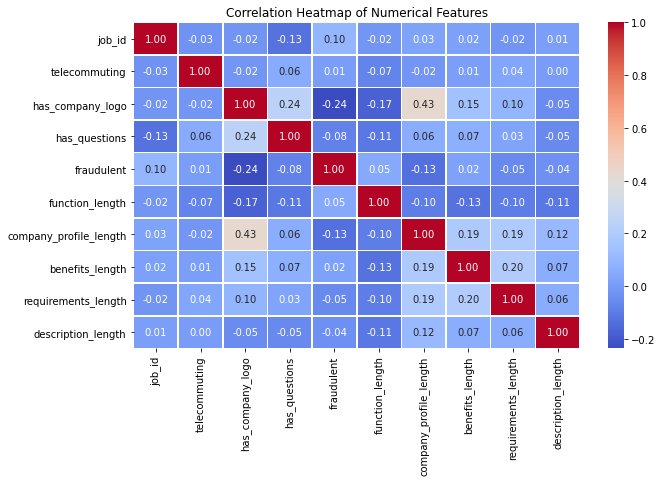

In [99]:
# Selecting only the numerical columns
numerical_columns = df.select_dtypes(include='number')

# Computing the correlation matrix
corr_matrix = numerical_columns.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


Plotting a correlation heatmap for all numerical columns, including the target variable `fraudulent`.

- The heatmap shows how strongly pairs of features are related (values range from -1 to 1).
- High positive values (close to 1) indicate a strong direct relationship.
- High negative values (close to -1) indicate a strong inverse relationship.
- Values near 0 suggest no linear correlation.

This helps us understand relationships between features and can guide feature selection for modeling.


**Location Analysis**

We analyze the most common job posting locations to identify any geographic patterns. This may help reveal whether certain locations are more associated with fraudulent job posts.


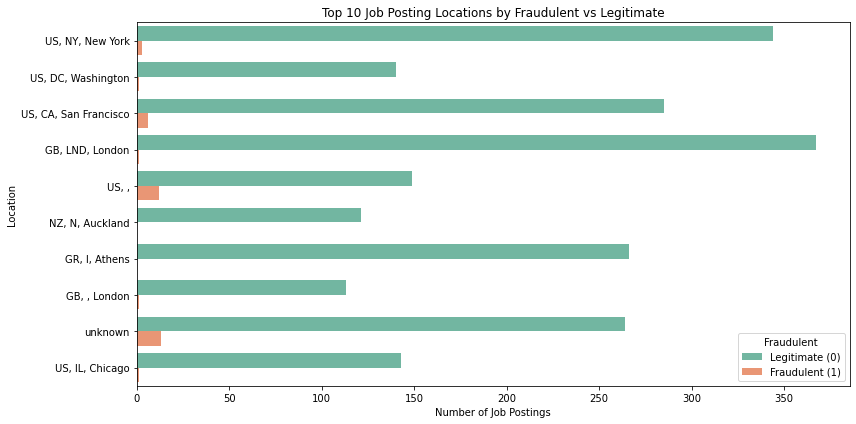

In [102]:
top_locations = df['location'].value_counts().head(10).index

# Filtering for only those top locations
top_location_df = df[df['location'].isin(top_locations)]

plt.figure(figsize=(12, 6))
sns.countplot(data=top_location_df, y='location', hue='fraudulent', palette='Set2')
plt.title('Top 10 Job Posting Locations by Fraudulent vs Legitimate')
plt.xlabel('Number of Job Postings')
plt.ylabel('Location')
plt.legend(title='Fraudulent', labels=['Legitimate (0)', 'Fraudulent (1)'])
plt.tight_layout()
plt.show()


The plot highlights the top 10 job posting locations. We can observe which cities or regions have a higher count of fraudulent job postings, helping identify any geographic risk factors.


**Fraud Rate by Top Locations**

This plot shows the proportion of fraudulent postings in each top location, highlighting riskier geographic areas.



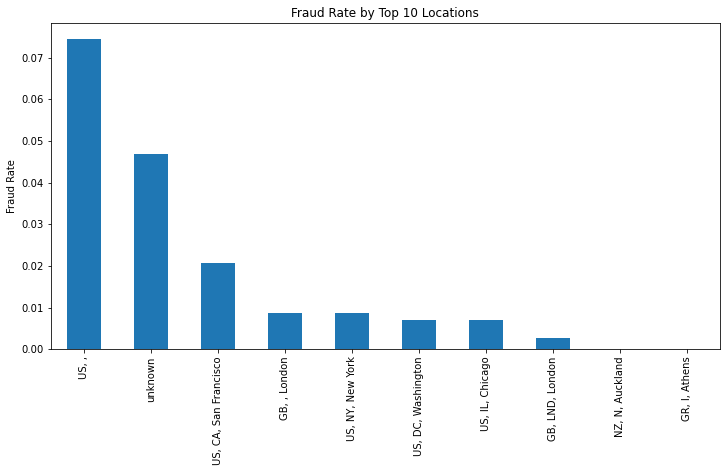

In [104]:
location_fraud_rate = df.groupby('location')['fraudulent'].mean().loc[top_locations].sort_values(ascending=False)
plt.figure(figsize=(12,6))
location_fraud_rate.plot(kind='bar')
plt.title('Fraud Rate by Top 10 Locations')
plt.ylabel('Fraud Rate')
plt.show()
